# Cluster Analysis

In [19]:
import pandas as pd 
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np

Run this line to import utils:

In [20]:
%run ../../utils/utils.py

## 1. Load Data

In [21]:
df = pd.read_csv('../../data/featured_data.csv')
df.head()

,s1_edad,s1_genero,s1_experiencia_clinica,s1_educacion,s1_titulo_terciario,s1_titulo,s1_no_titulo_universitario,s1_horas_semana_pacientes_atendidos,s1_contexto_trabajo,s1_orientacion_teo,...,s4_no_tiempo_aprender_tbe,s4_capacitacion_tbe_demasiado_dinero,s4_no_saber_tbe,s4_entrenamiento_clinico_no_info_tbe,s4_alianza_terapeutica_mas_importante,s4_terapias_igualmente_efectivas,s4_empleador_no_fondos_capacitacion_tbe,s4_exp_clinica_mas_importante_que_evidencia_cientifica,provincia_residencia,consentimiento_informado
0,41.0,Femenino,1.2,Licenciatura de Grado,NaN,Lic. en Psicología,NaN,12.0,Ámbito Privado,Ecléctico (más de una de estas opciones),...,4.0,4.0,7.0,0.0,6.0,4.0,6.0,2.0,Provincia de Buenos Aires,NaN
1,26.0,Femenino,0.2,Licenciatura de Grado,NaN,Lic. en Psicología,NaN,13.0,"Ámbito Privado, Obra Social o Prepaga",Terapias Cognitivas/Comportamentales,...,1.0,6.0,1.0,0.0,4.0,2.0,7.0,3.0,Provincia de Buenos Aires,NaN
2,27.0,Femenino,1.0,Carrera de Especialización,NaN,Lic. en Psicología,NaN,30.0,"Ámbito Privado, Obra Social o Prepaga",Terapias Cognitivas/Comportamentales,...,1.0,4.0,1.0,1.0,1.0,1.0,0.0,4.0,Ciudad Autónoma de Buenos Aires (CABA),NaN
3,30.0,Masculino,1.3,Carrera de Especialización,NaN,Lic. en Psicología,NaN,35.0,Ámbito Privado,Terapias Cognitivas/Comportamentales,...,2.0,3.0,0.0,4.0,3.0,0.0,7.0,3.0,Provincia de Buenos Aires,NaN
4,26.0,Masculino,2.0,Licenciatura de Grado,NaN,Lic. en Psicología,NaN,46.0,Ámbito Público (hospital u otro),Terapias Cognitivas/Comportamentales,...,4.0,6.0,1.0,4.0,4.0,1.0,7.0,4.0,Provincia de Buenos Aires,NaN


In [22]:
df_subset_s2 = create_section_2(df)
variables_s2 = ['s2_evidencia_cientifica', 's2_experiencia_personal', 's2_entrenamiento_clinica',
             's2_tratamiento_preferencia_consultantes', 's2_intuicion', 's2_terapia_personal']

df_subset_s3 = create_section_3(df) 
variables_s3 = ['s3_tratamiento_personal_consultantes', 's3_investigacion_empirica_ensayos_controlados',
             's3_supervision', 's3_estudios_de_caso', 's3_discusion_pares', 's3_libros', 
             's3_observaciones_casos_clinicos', 's3_medidas_resultado', 's3_guias_manuales_clinicos']

df_subset_s4 = create_section_4(df)

# List of variables for which you want to create point plots
variables_s4 = ['s4_apertura_terapias_desarrolladas_por_investigadores', 's4_nueva_terapia_intento',
             's4_terapia_manualizada', 's4_diagnosticos_utilizados_son_simples', 
             's4_tratamientos_preferencia_no_probados_ensayo_controlado', 's4_enfoque_tratamiento_individual', 
             's4_alianza_terapeutica_mas_importante', 's4_terapias_igualmente_efectivas', 
             's4_exp_clinica_mas_importante_que_evidencia_cientifica', 's4_actualizacion_info_cientifica', 
             's4_formacion_enfasis_investigacion', 's4_supervisores_terapia_evidencia_requerimiento', 
             's4_atraer_consultantes_con_tbe', 's4_hallazgos_cientificos_practica_diaria', 
             's4_interes_aprender_tbe', 's4_tratamientos_utilizados_base_empirica', 
             's4_complejidad_consultantes_ensayos_clinicos', 's4_consultantes_prefieren_otros_tratamientos', 
             's4_no_tiempo_aprender_tbe', 's4_capacitacion_tbe_demasiado_dinero', 
             's4_no_saber_tbe', 's4_entrenamiento_clinico_no_info_tbe', 
             's4_empleador_no_fondos_capacitacion_tbe'] 

## Cluster Analysis

In [23]:
# Combine data from all sections
all_sections = pd.concat([df_subset_s2[variables_s2], 
                          df_subset_s3[variables_s3], 
                          df_subset_s4[variables_s4]], axis=1)

# Add demographic variables for chi-square tests (optional)
demographic_vars = ['s1_orientacion_teo', 's1_edad', 's1_genero', 's1_horas_semana_pacientes_atendidos']
all_data = pd.concat([all_sections, df_subset_s2[demographic_vars]], axis=1)

# Clean data (drop rows with missing values)
all_data_clean = all_data.dropna()

# Separate features and target variable (optional for chi-square tests)
features = all_data_clean.drop(columns=demographic_vars)
target = all_data_clean['s1_orientacion_teo']

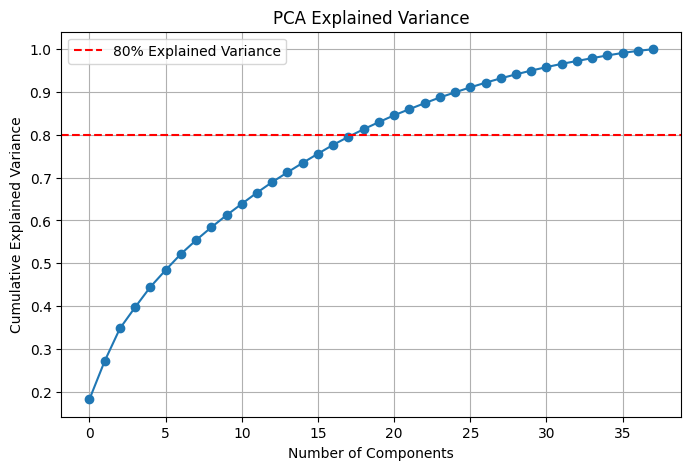

Number of components to retain: 19


/Users/axelcasas/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/axelcasas/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/axelcasas/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/axelcasas/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init

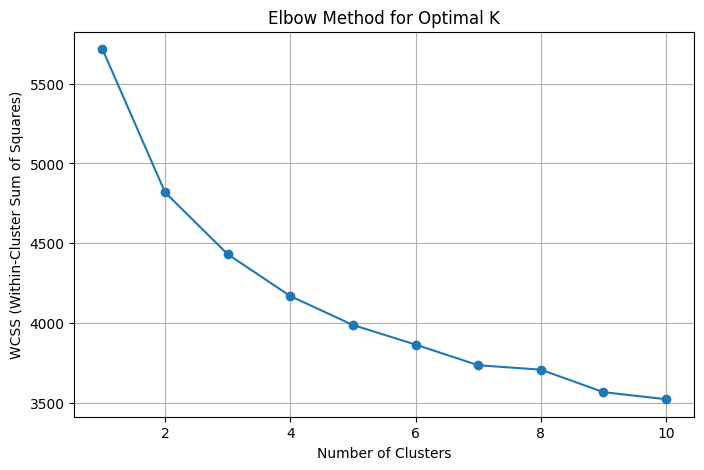

/Users/axelcasas/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Optimal number of clusters: 4


/var/folders/v7/nr6md6710570s7bpqsf_w7m80000gn/T/ipykernel_11109/2667234829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_clean['Cluster'] = cluster_labels


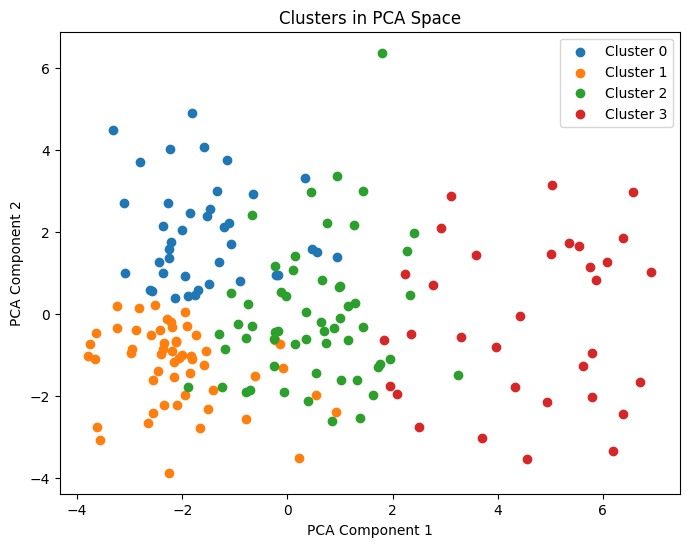


--- Chi-Square Test ---
Chi²: 70.30, p: 1.3306e-11, DOF: 9
s1_orientacion_teo  Ecléctico (más de una de estas opciones)  Psicoanálisis   
Cluster                                                                       
0                                                          4              0  \
1                                                          6              8   
2                                                         10             22   
3                                                          4             25   

s1_orientacion_teo  Sistémica  Terapias Cognitivas/Comportamentales  
Cluster                                                              
0                           2                                    34  
1                           6                                    35  
2                           5                                    20  
3                           1                                     3  

--- PCA Loadings ---
                       

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

# Standardize the features before PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA
pca = PCA()
pca_data = pca.fit_transform(features_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# Determine optimal number of components (e.g., 80% variance)
n_components = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Number of components to retain: {n_components}")

pca = PCA(n_components=n_components)
pca_reduced_data = pca.fit_transform(features_scaled)

# K-Means: Determine optimal clusters using Elbow Method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_reduced_data)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

# Identify optimal clusters
optimal_k = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing").knee
print(f"Optimal number of clusters: {optimal_k}")

# Fit K-Means with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(pca_reduced_data)

# Add cluster labels to the data
all_data_clean['Cluster'] = cluster_labels

# Visualize clusters in 2D PCA space
plt.figure(figsize=(8, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_reduced_data[cluster_labels == cluster, 0], 
                pca_reduced_data[cluster_labels == cluster, 1], 
                label=f'Cluster {cluster}')
plt.title('Clusters in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Chi-Square Test
cross_tab = pd.crosstab(all_data_clean['Cluster'], all_data_clean['s1_orientacion_teo'])
chi2, p, dof, expected = chi2_contingency(cross_tab)
print("\n--- Chi-Square Test ---")
print(f"Chi²: {chi2:.2f}, p: {p:.4e}, DOF: {dof}")
print(cross_tab)

# PCA Loadings
loadings = pd.DataFrame(pca.components_.T, index=features.columns, 
                        columns=[f'PC{i+1}' for i in range(n_components)])
print("\n--- PCA Loadings ---")
print(loadings)


In [25]:
import numpy as np
n = cross_tab.values.sum()  # Total number of observations
r, k = cross_tab.shape      # Rows and columns of the table
cramers_v = np.sqrt(chi2 / (n * (min(r-1, k-1))))
print(f"Cramér's V: {cramers_v:.2f}")

Cramér's V: 0.36


In [26]:
# Add cluster labels to the original features
cluster_data = features.copy()
cluster_data['Cluster'] = cluster_labels

# Compute mean values of variables for each cluster
cluster_means = cluster_data.groupby('Cluster').mean()

# Display cluster profiles
print("\nCluster Profiles (Variable Means):")
print(cluster_means)

# Optional: Visualize profiles using radar plots or heatmaps


Cluster Profiles (Variable Means):
         s2_evidencia_cientifica  s2_experiencia_personal   
Cluster                                                     
0                       6.500000                 3.725000  \
1                       6.345455                 6.127273   
2                       5.157895                 5.754386   
3                       3.666667                 5.878788   

         s2_entrenamiento_clinica  s2_tratamiento_preferencia_consultantes   
Cluster                                                                      
0                        4.050000                                 1.950000  \
1                        6.218182                                 4.000000   
2                        5.543860                                 4.210526   
3                        5.848485                                 3.666667   

         s2_intuicion  s2_terapia_personal   
Cluster                                      
0            2.175000             2.

In [27]:
# Calculate standard deviation across clusters for each variable
std_across_clusters = cluster_means.std(axis=0)

# Sort by importance (higher std means greater difference across clusters)
sorted_variables = std_across_clusters.sort_values(ascending=False)
print("Variables with highest variation across clusters:")
print(sorted_variables.head(10))

Variables with highest variation across clusters:
s4_interes_aprender_tbe                                   2.356079
s4_atraer_consultantes_con_tbe                            2.311286
s4_tratamientos_utilizados_base_empirica                  2.219711
s4_hallazgos_cientificos_practica_diaria                  2.200987
s4_actualizacion_info_cientifica                          2.180217
s4_supervisores_terapia_evidencia_requerimiento           1.976189
s4_formacion_enfasis_investigacion                        1.524165
s4_exp_clinica_mas_importante_que_evidencia_cientifica    1.497151
s4_capacitacion_tbe_demasiado_dinero                      1.420487
s3_investigacion_empirica_ensayos_controlados             1.346197
dtype: float64


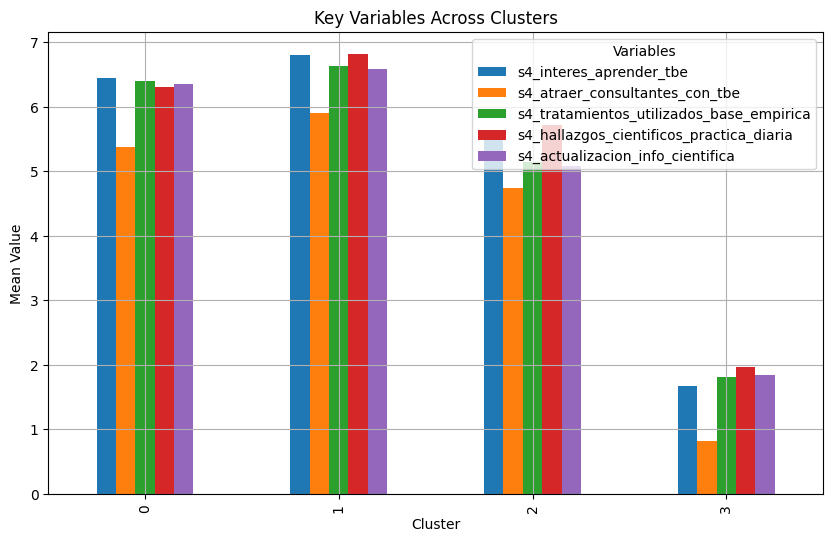

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Top 5 variables with highest variation
top_variables = sorted_variables.head(5).index

# Plot means of these variables across clusters
cluster_means[top_variables].plot(kind="bar", figsize=(10, 6))
plt.title("Key Variables Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Mean Value")
plt.legend(title="Variables")
plt.grid(True)
plt.show()

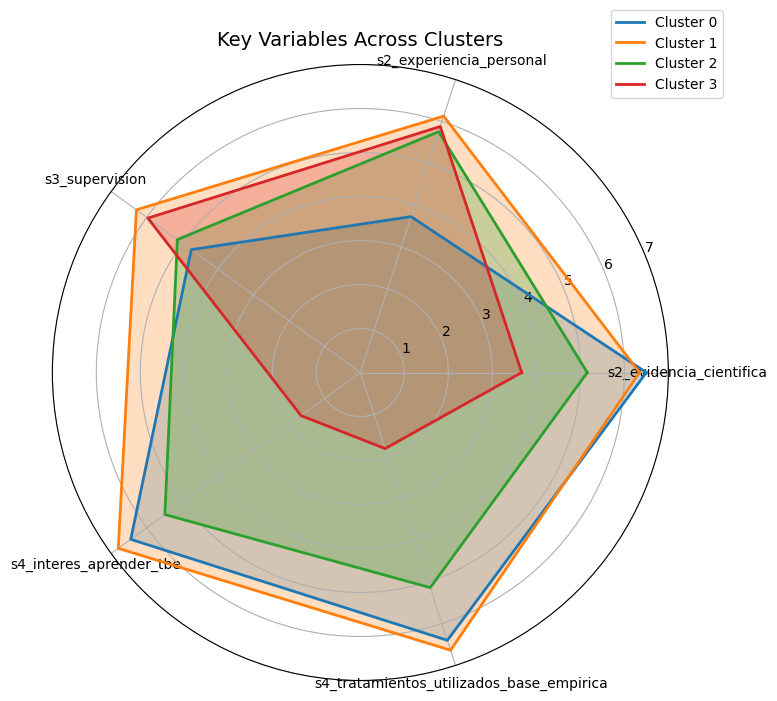

In [29]:
# Use the actual means instead of normalized values
top_variables = [
    "s2_evidencia_cientifica", "s2_experiencia_personal", 
    "s3_supervision", "s4_interes_aprender_tbe", 
    "s4_tratamientos_utilizados_base_empirica"
]

# Reduce the cluster means to the selected top variables
actual_means = cluster_means[top_variables]

# Radar plot setup
angles = np.linspace(0, 2 * np.pi, len(top_variables), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Iterate over each cluster
for cluster in actual_means.index:
    values = actual_means.loc[cluster].tolist()
    values += values[:1]  # Close the circle
    ax.plot(angles, values, label=f"Cluster {cluster}", linewidth=2)
    ax.fill(angles, values, alpha=0.25)

# Set axis labels and legend
ax.set_xticks(angles[:-1])
ax.set_xticklabels(top_variables, fontsize=10)
ax.set_title("Key Variables Across Clusters", fontsize=14)
ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))

# Adjust radial limits to match the scale (e.g., Likert scale of 1-7)
ax.set_ylim(0, 7)  # Assuming Likert scale minimum = 1 and maximum = 7

plt.show()


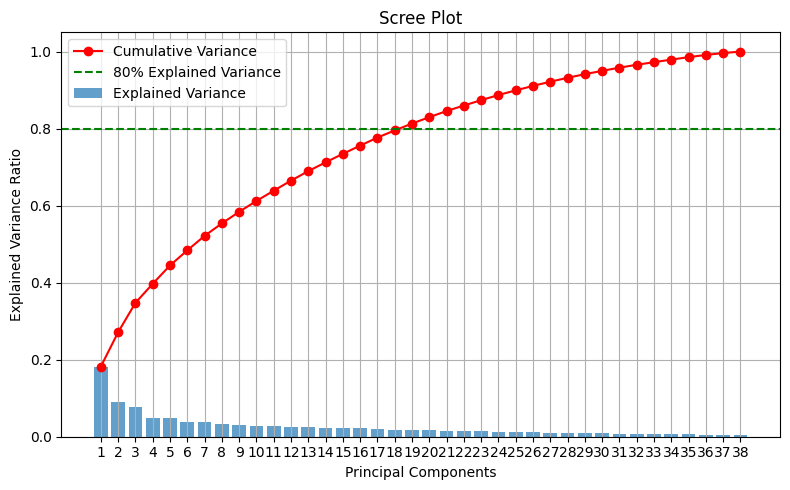

In [30]:
# Necessary imports for scree plot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming the data preprocessing and feature selection steps are completed
# 'features_scaled' contains the scaled features

# Perform PCA
pca = PCA()
pca_data = pca.fit_transform(features_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Create Scree Plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label="Explained Variance")
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label="Cumulative Variance", color='r')
plt.axhline(y=0.8, color='g', linestyle='--', label='80% Explained Variance')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

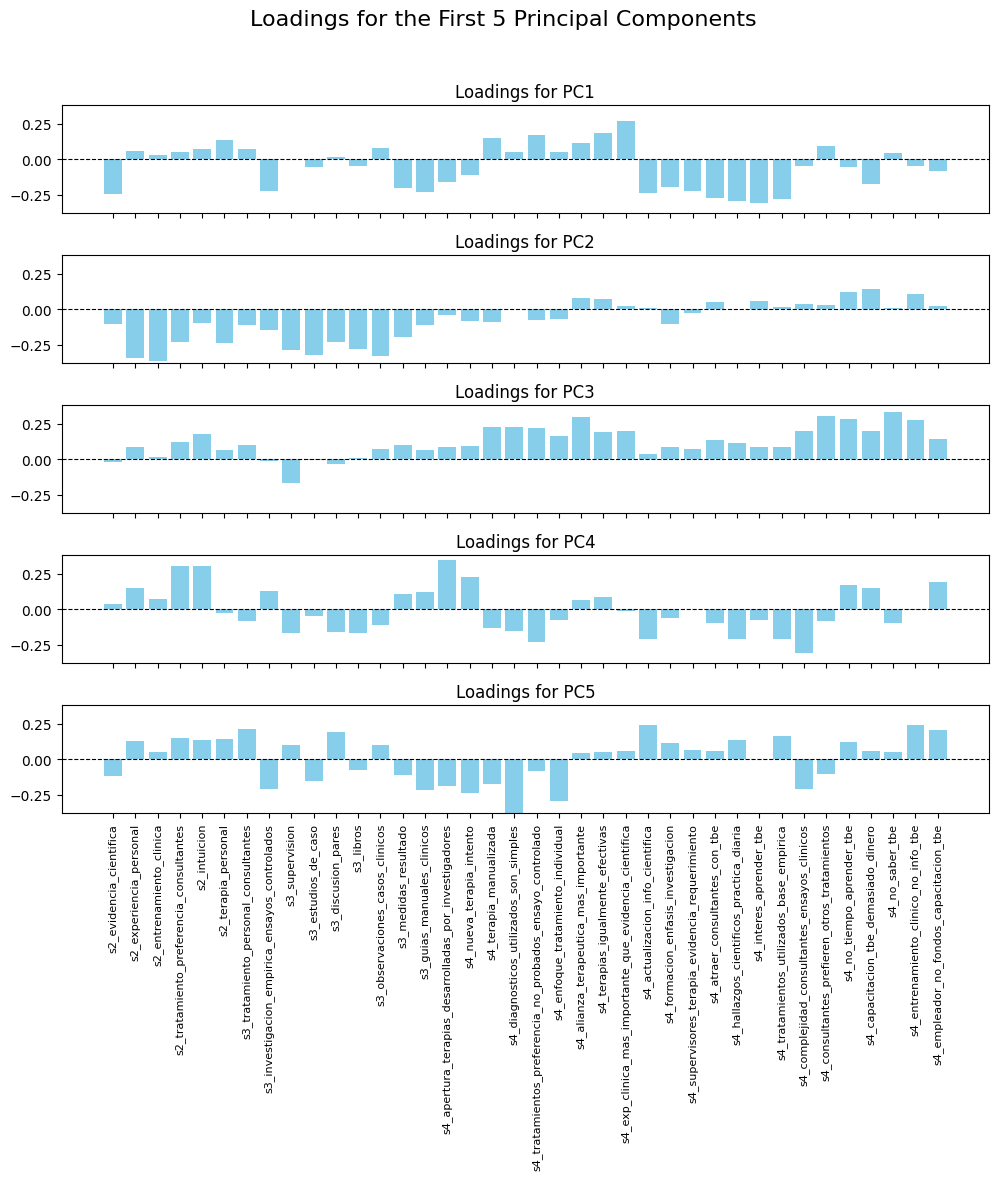

In [31]:
# Loadings for the first 5 principal components
loadings = pd.DataFrame(pca.components_[0:5, :], columns=features.columns)

# Maximum value for scaling purposes
maxPC = 1.01 * np.max(np.abs(loadings.values))

# Create subplots for each of the first 5 components
fig, axes = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.iloc[i, :]
    ax.bar(pc_loadings.index, pc_loadings.values, color='skyblue')
    ax.set_ylim(-maxPC, maxPC)
    ax.set_title(f"Loadings for PC{i+1}", fontsize=12)
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.tick_params(axis='x', rotation=90, labelsize=8)

fig.suptitle("Loadings for the First 5 Principal Components", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

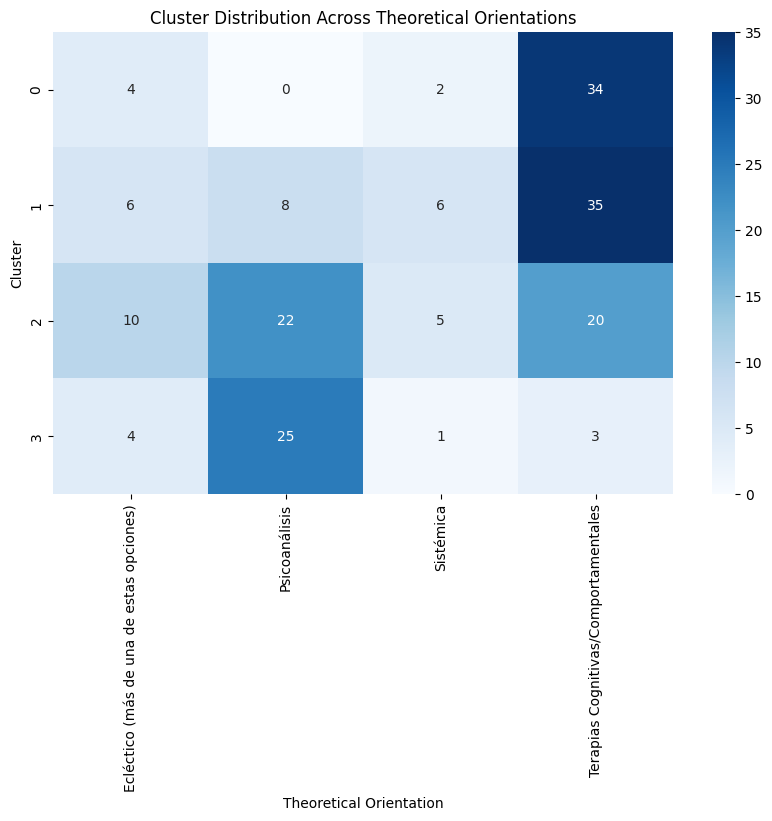

In [32]:
# Cluster Distribution Across Orientations (Heatmap)
cluster_distribution = pd.crosstab(all_data_clean['Cluster'], all_data_clean['s1_orientacion_teo'])
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_distribution, annot=True, fmt='d', cmap='Blues')
plt.title('Cluster Distribution Across Theoretical Orientations')
plt.xlabel('Theoretical Orientation')
plt.ylabel('Cluster')
plt.show()

## Cluster Results (to update)

To further study the relationship of different theoretical orientations, we performed a cluster analysis. Three clusters were identified: cluster 0) dominated by Psychoanalysis (27), with minor representation from Eclectic (5), Systemic (1), and CBT (3), cluster 1) dominated by CBT (52), with smaller representation from Systemic (4) and Eclectic (7), none representatives from Psychoanalysis, and cluster 2) A mixeg group with a significant representation of Psychoanalysis (28), CBT (37), Eclectic (12), and Systemic (9). A Chi-Square analysis give a result of 73.02 (p<0.001) and 6 degrees of freedom. These results suggest that the theoretical orientation is significantly associated with cluster membership, confirming that clusters capture meaningfull differences among psychological practioners. 

Finally, we conducted a principal component analysis (PCA) to reduce dimensionality and identify the most influential variables for clustering (table). Nineteen out of 35 principal components explained 80% of the variance. PC1 showed strong positive contributions from evidence-based practice indicators (use of scientific evidence = 0.2448, use of scientific findings during the daily practice = 0.2928, interest in learning science-based therapies (0.3063)). For PC2, we found variables reflecting reliance on clinical expertise and supervision (personal therapy = 0.3413, clinic training = 0.3637, supervision = 0.2871). Finally, PC3 was found to be associated with barriers to evidence-based training (lack of knowledge about science-based therapies = 0.3354, no time to learn science-based therapies, science-based formation requires much money = 0.1764). 

Our results showed distinc profiles based on significant variables identified in PCA. For instance, Cluster 0, primarily composed by psychoanalysis, has a strong reliance on intuition and clininal experience. On the other hand, Cluster 1 presents a high adherence to evidence-based practices, primarily composed by CBT. Finally, cluster 2 showed a mixed profile, with a big representation of both Psychoanalysis and CBT. Interestingly, 


--- Descriptive Statistics for Age ---
         count       mean        std   min   25%   50%   75%   max
Cluster                                                           
0         40.0  30.625000   5.428734  24.0  27.0  30.0  33.0  55.0
1         55.0  32.327273   6.804287  21.0  27.5  30.0  36.5  49.0
2         57.0  36.087719   9.705081  23.0  28.0  34.0  41.0  61.0
3         33.0  39.454545  11.130170  27.0  31.0  36.0  44.0  77.0


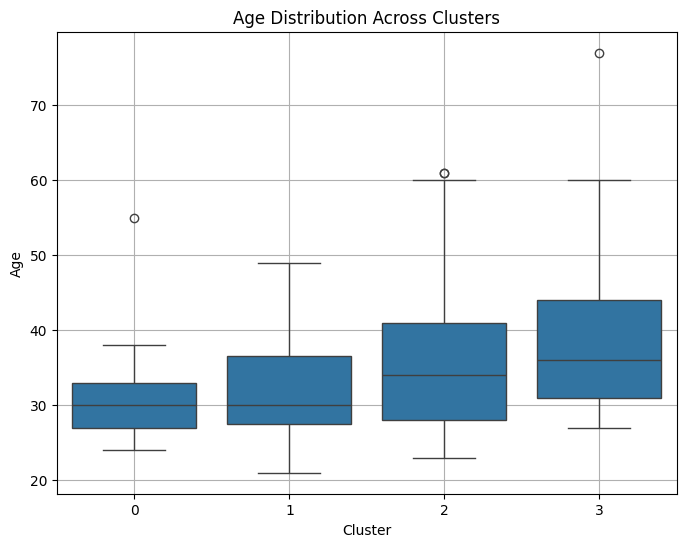

ANOVA Result: F=6.52, p=0.0019
Kruskal-Wallis Result: H=8.63, p=0.0133
Optimization terminated successfully.
         Current function value: 0.596100
         Iterations 6

--- Logistic Regression Summary ---
                           Logit Regression Results                           
Dep. Variable:           is_cluster_2   No. Observations:                  185
Model:                          Logit   Df Residuals:                      183
Method:                           MLE   Df Model:                            1
Date:                Fri, 24 Jan 2025   Pseudo R-squ.:                 0.02047
Time:                        14:19:58   Log-Likelihood:                -110.28
converged:                       True   LL-Null:                       -112.58
Covariance Type:            nonrobust   LLR p-value:                   0.03181
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


/var/folders/v7/nr6md6710570s7bpqsf_w7m80000gn/T/ipykernel_11109/2597075855.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_clean['is_cluster_2'] = (all_data_clean['Cluster'] == 1).astype(int)


In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal
from statsmodels.formula.api import logit

# Filter data for Cluster 2
cluster_2_data = all_data_clean[all_data_clean['Cluster'] == 2]

# Descriptive statistics for age across all clusters
age_stats = all_data_clean.groupby('Cluster')['s1_edad'].describe()
print("\n--- Descriptive Statistics for Age ---")
print(age_stats)

# Boxplot for age distribution across clusters
plt.figure(figsize=(8, 6))
sns.boxplot(data=all_data_clean, x='Cluster', y='s1_edad')
plt.title('Age Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.grid(True)
plt.show()

# Statistical test for age differences (ANOVA or Kruskal-Wallis)
anova_result = f_oneway(
    all_data_clean[all_data_clean['Cluster'] == 0]['s1_edad'],
    all_data_clean[all_data_clean['Cluster'] == 1]['s1_edad'],
    all_data_clean[all_data_clean['Cluster'] == 2]['s1_edad']
)
print(f"ANOVA Result: F={anova_result.statistic:.2f}, p={anova_result.pvalue:.4f}")

# If ANOVA is not suitable (non-normal data), use Kruskal-Wallis
kruskal_result = kruskal(
    all_data_clean[all_data_clean['Cluster'] == 0]['s1_edad'],
    all_data_clean[all_data_clean['Cluster'] == 1]['s1_edad'],
    all_data_clean[all_data_clean['Cluster'] == 2]['s1_edad']
)
print(f"Kruskal-Wallis Result: H={kruskal_result.statistic:.2f}, p={kruskal_result.pvalue:.4f}")

# Logistic regression to predict belonging to Cluster 2
# Create a binary variable for Cluster 2
all_data_clean['is_cluster_2'] = (all_data_clean['Cluster'] == 1).astype(int)

# Logistic regression model
logit_model = logit("is_cluster_2 ~ s1_edad", data=all_data_clean).fit()
print("\n--- Logistic Regression Summary ---")
print(logit_model.summary())
